In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# all dims in meters
IN_TO_METERS = 0.0254
# https://www.dropbox.com/sh/bcnsqxhntwaoxdq/AABFhMAjY68ykwWP5YUB-46za?dl=0&preview=26624a+MIRROR+P1.pdf
# Which dim is considered X and which is Y will depend on how the mapper is mounted on the mirror.
# Verify this before using the files.
MIRRORS = {
    'P1': np.array([23.622, 19.685]) * IN_TO_METERS,
    'K1': np.array([23.622, 18.110]) * IN_TO_METERS,
    'K2': np.array([25.590, 25.590]) * IN_TO_METERS,
    'K3': np.array([29.530, 21.650]) * IN_TO_METERS,
    'F1': np.array([31.496, 18.110]) * IN_TO_METERS,
    # P2 not accessible, not mapped
}
# Which groups of IR-50s to use for each mirror (really, the index of the LabJack addresses):
# 0 = center, 1 = inner ring of six, 2 = outer ring of six, rest = unused
# There are twelve.
# This decision depends on how spread out the beam pattern is on each optic.
HAWKEYES = {
    'P1': np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'K1': np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'K2': np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'K3': np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    'F1': np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    # P2 not accessible, not mapped
}

PROFILE_HEADER = 'flasher_cmds,pos_cmd_0s,pos_cmd_1s\n'

In [6]:
def raster(num_x, num_y, dim_x, dim_y, offset_x, offset_y, plot=False, name=''):
    X,Y = np.meshgrid(
        np.linspace(-dim_x/2, dim_x/2, num=num_x)[::-1] + offset_x,
        np.linspace(-dim_y/2, dim_y/2, num=num_y)[::-1] + offset_y
    )
    if plot:
        fig, ax = plt.subplots(figsize=(9,16))
        order = 0 
    # step through points in a raster scan, starting top left
    for i in range(X.shape[0]):
        if not i % 2:
            X[i,:] = X[i,::-1]
            Y[i,:] = Y[i,::-1]
        if plot:
            for j in range(X.shape[1]):
                ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
                order += 1
    if plot:
        ax.scatter(X,Y)
        ax.set_xlabel('X-coord in mirror frame (m)')
        ax.set_ylabel('Y-coord in mirror frame (m)')
        if name:
            ax.set_title(f'Optic: {name}')
        ax.set_aspect('equal')
        ax.grid(True)

    return X,Y


def raster_skipline_SE(num_x, num_y, dim_x, dim_y, offset_x, offset_y, plot=False, name=''):
    '''
    Ordered for photogrammetry picture-taking, starts in SE
    '''
    X,Y = np.meshgrid(
        np.linspace(-dim_x/2, dim_x/2, num=num_x)[::1] + offset_x,
        np.linspace(-dim_y/2, dim_y/2, num=num_y)[::1] + offset_y
    )
    if plot:
        fig, ax = plt.subplots(figsize=(9,16))
        order = 0 
    # step through points in a raster scan, starting bottom left
    for i in range(X.shape[0]):
        # if not i % 2:
            # X[i,:] = X[i,::-1]
            # Y[i,:] = Y[i,::-1]
        if plot:
            for j in range(X.shape[1]):
                ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
                order += 1
    if plot:
        ax.scatter(X,Y)
        ax.set_xlabel('X-coord in mirror frame (m)')
        ax.set_ylabel('Y-coord in mirror frame (m)')
        if name:
            ax.set_title(f'Optic: {name}')
        ax.set_aspect('equal')
        ax.grid(True)

    return X,Y


def raster_skipline_NW(num_x, num_y, dim_x, dim_y, offset_x, offset_y, plot=False, name=''):
    '''
    Ordered for photogrammetry picture-taking, but starts at NW instead of SE
    '''
    X,Y = np.meshgrid(
        np.linspace(-dim_x/2, dim_x/2, num=num_x)[::1] + offset_x,
        np.linspace(dim_y/2, -dim_y/2, num=num_y)[::1] + offset_y
    )
    if plot:
        fig, ax = plt.subplots(figsize=(9,16))
        order = 0 
    # step through points in a raster scan, starting bottom left
    for i in range(X.shape[0]):
        # if not i % 2:
            # X[i,:] = X[i,::-1]
            # Y[i,:] = Y[i,::-1]
        if plot:
            for j in range(X.shape[1]):
                ax.annotate(f'{order}', (X[i][j], Y[i][j]), fontsize=12)
                order += 1
    if plot:
        ax.scatter(X,Y)
        ax.set_xlabel('X-coord in mirror frame (m)')
        ax.set_ylabel('Y-coord in mirror frame (m)')
        if name:
            ax.set_title(f'Optic: {name}')
        ax.set_aspect('equal')
        ax.grid(True)

    return X,Y

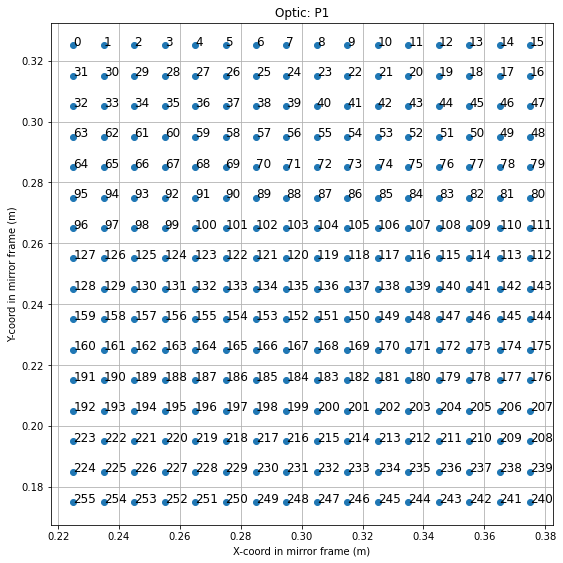

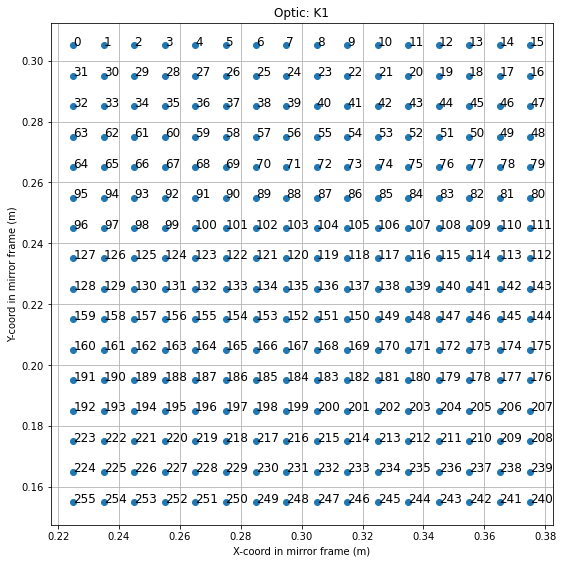

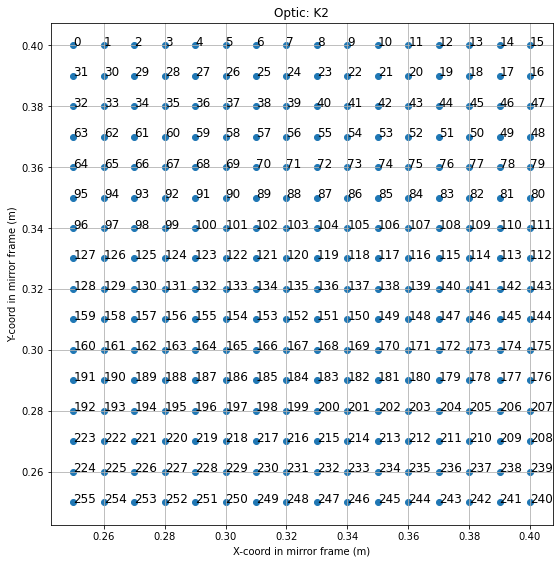

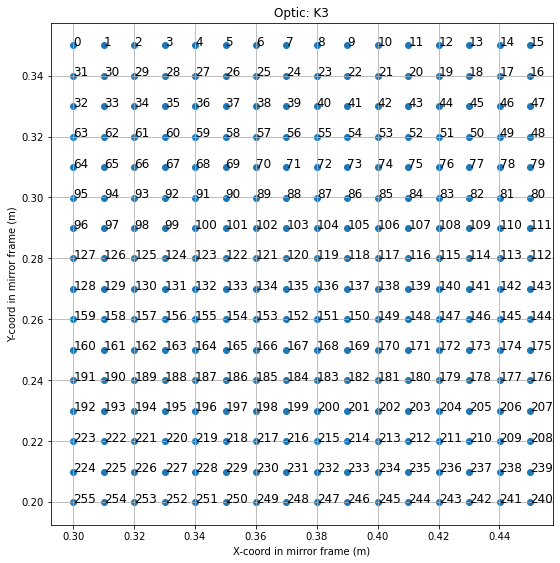

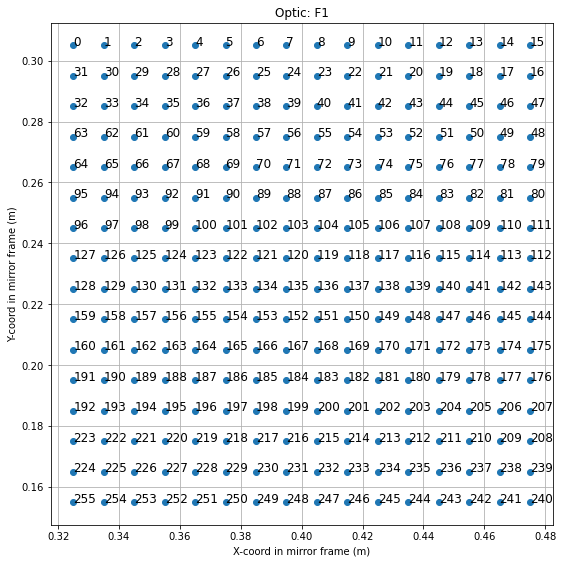

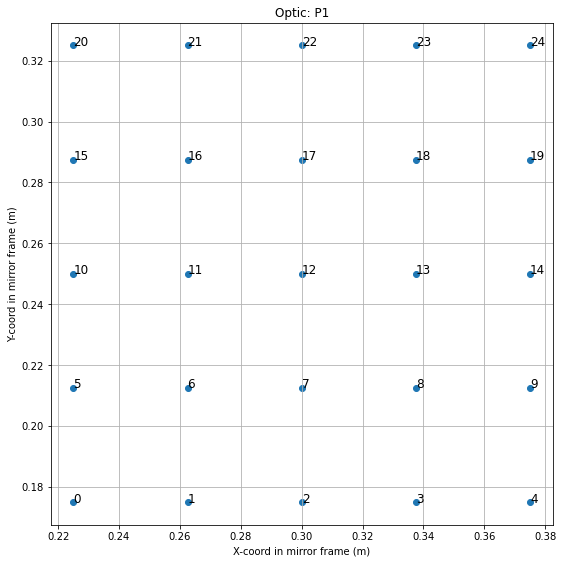

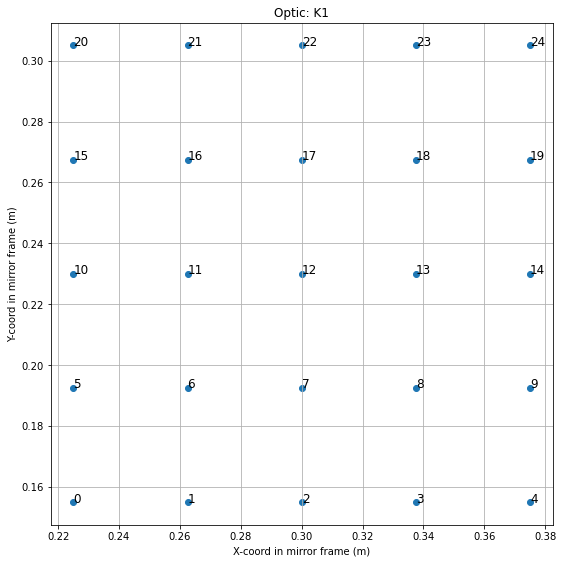

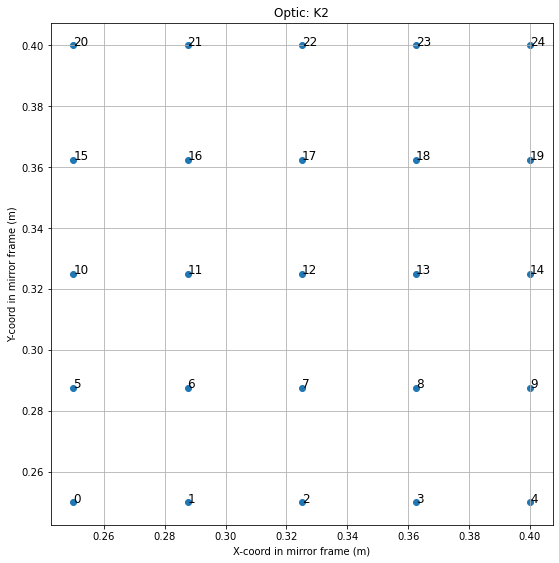

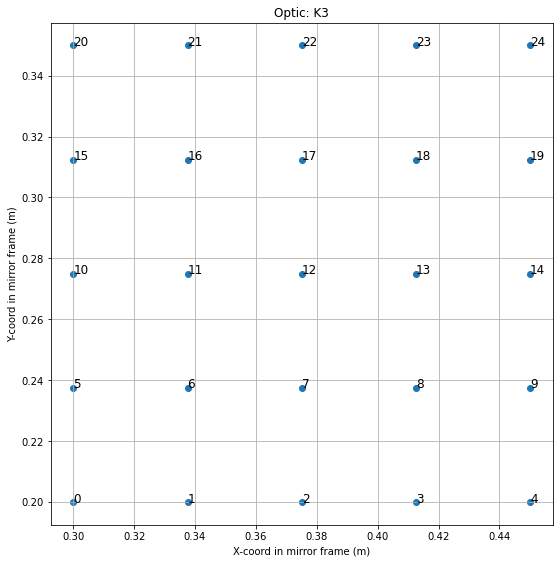

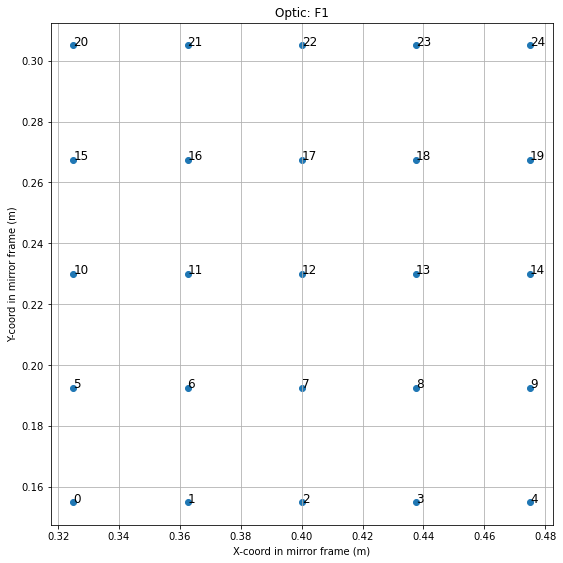

In [25]:
num_x = 16 # total num points per axis
num_y = 16
dim_x = .15 # total extent of region mapped
dim_y = .15

# Get a continuous raster pattern centered on each optic
for key in MIRRORS.keys():
    filename = key + '_raster' + '.csv'
    X,Y = raster(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2, plot=True, name=key)
    active_hawkeyes = HAWKEYES[key]
    
    with open(filename, 'w') as f:
        f.write(PROFILE_HEADER)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                hawkeye_str = ' '.join([str(elem) for elem in active_hawkeyes])
                line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
                f.write(line) 

In [ ]:
num_x = 5 # total num points per axis
num_y = 5
dim_x = .15 # total extent of region mapped
dim_y = .15
# Get a coarser, skipline raster pattern centered on each optic
for key in MIRRORS.keys():
    filename = key + '_raster_coarse' + '.csv'
    X,Y = raster_skipline_SE(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2, plot=True, name=key)
    active_hawkeyes = HAWKEYES[key]
    
    with open(filename, 'w') as f:
        f.write(PROFILE_HEADER)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                hawkeye_str = ' '.join([str(elem) for elem in active_hawkeyes])
                line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
                f.write(line) 

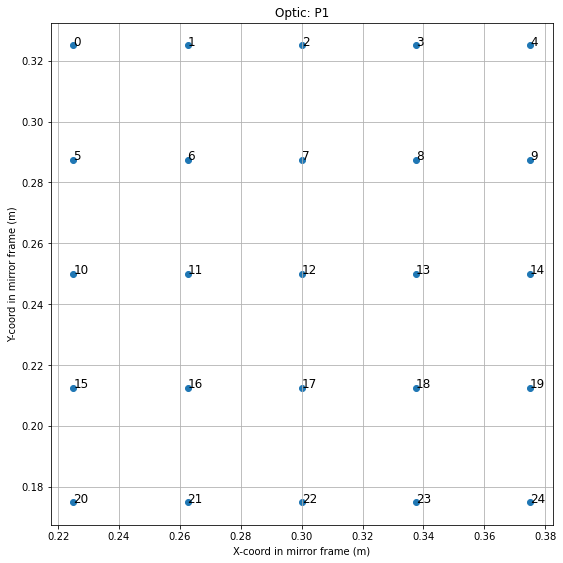

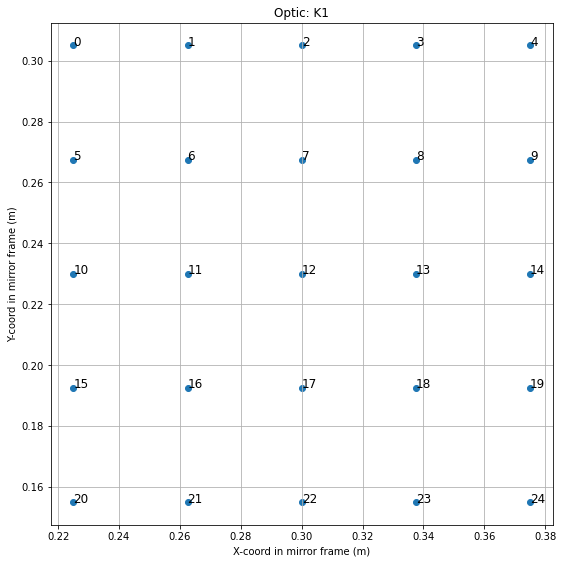

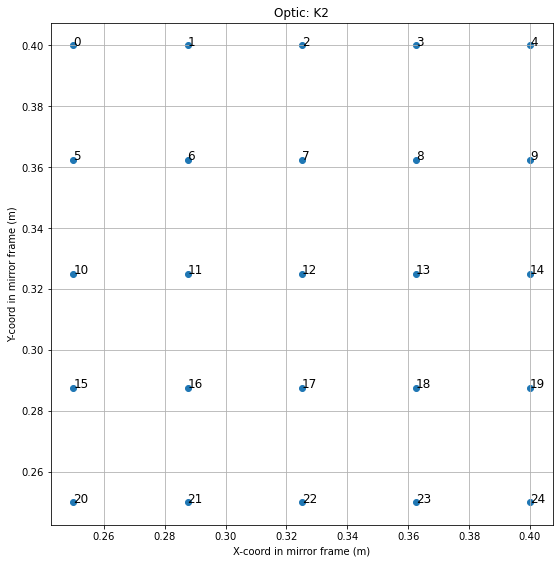

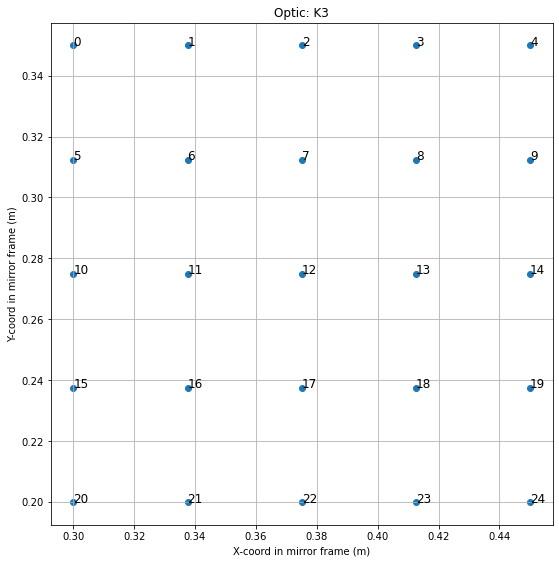

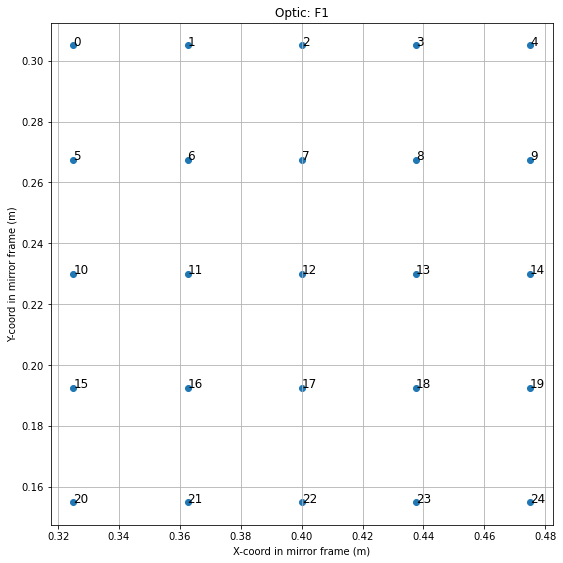

In [7]:

num_x = 5 # total num points per axis
num_y = 5
dim_x = .15 # total extent of region mapped
dim_y = .15
# Get a coarser, skipline raster pattern centered on each optic
for key in MIRRORS.keys():
    filename = key + '_raster_coarse_NW' + '.csv'
    X,Y = raster_skipline_NW(num_x, num_y, dim_x, dim_y, MIRRORS[key][0]/2, MIRRORS[key][1]/2, plot=True, name=key)
    active_hawkeyes = HAWKEYES[key]
    
    with open(filename, 'w') as f:
        f.write(PROFILE_HEADER)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                hawkeye_str = ' '.join([str(elem) for elem in active_hawkeyes])
                line = ','.join([hawkeye_str, str(X[i][j]), str(Y[i][j])]) + '\n'
                f.write(line) 